# Recommending Steepster users to follow with Jaccard similarity

## Business case

On the Steepster social network, users can follow one another to read tealogs, swap teas, and otherwise stay in touch. The business problem here, of all the possible users in the network, which users should be recommended to the active user?

One way to look at this is to say that if the active user follows many of the same people as another user, then the active user and that other user may have common tastes; therefore, the active user might be interested in following that other user.

## Finding similar users

Follower data is unary - either user `u` follows user `v` or they do not. This is exactly the type of data the Jaccard index (aka Jaccard coefficient, Jaccard similarity) is made for. In a directed graph, the Jaccard index is calculated by comparing the set of users followed by user `u` to the set of users followed by user `v`, dividing the count users that appear in both sets by the total count of distinct users in the two sets.

If you're a mathy person, here's the formula straight from the NetworkX docs: 

$$
  \frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}
$$

For non-mathy people (like me), in English that means:

$$
  \frac{Users Both People Follow}{Distinct Users Either Person Follows}
$$

> ### Example
> 
> Let's calculate a Jaccard coefficient for two users:
> * Alice follows Carol and Derek
> * Bob follows Carol and Edward
> * How many users do they have in common? One: Carol.
> * How many total users do they follow? Three: Carol, Derek, and Edward.
> * Therefore, their Jaccard coefficient is 1/3 = 0.33
>   
> Does that mean that we should recommend to Alice that she follow Bob? Maybe. First, we have to calculate her Jaccard coefficients with other users and then rank them. If we find that Bob has the highest Jaccard coefficient for Alice, then he might be the best user to recommend to her.


## Global settings and imports

In [1]:
import jaccard_recs as jr
import networkx as nx
import matplotlib.pyplot as plt
import random

## Load and split data

After loading the data and creating an edgelist, we will split the data randomly into `train` and `test` sets so we can evaluate the method's performance on unseen edges in the network. Then we create a directed graph from the edgelist and time the network down slightly using NetworkX's `k_core` function with `k` set to 2. This will remove any nodes that have only one connection.

> **Note:** Nodes with only one connection cannot appear in both the training and test set, so they will only decrease model performance. We can implement something separate for them later, like recommending the Top N most popular users.  


In [2]:
user_dict = jr.import_user_dict(filepath="..\\data\\pickled-data\\user_dict.p")

In [3]:
edges = jr.edgelist_from_user_dict(user_dict)

In [4]:
train, test = jr.train_test_split_edgelist(edges)

In [5]:
G = nx.k_core(nx.DiGraph(train), k=2)

## Calculate Jaccard coefficients

Now we calculate Jaccard coefficients for every possible `(u, v)` node pair in the network. This could be made more efficient by only considering nodes within a given number of hops or in a community subgraph. It also runs more quickly if a larger `k` is chosen in k-cores, but the drawback there is that it removes nodes from the training graph.

In [9]:
all_jaccard_coefficients = list(jr.jaccard_coefficient(G))

## Recommendation and evaluation

### Recommendations
The top recommendation for someone to follow would be the user with the highest Jaccard coefficient. We can view sorted coefficients for a given active user and top target users by passing the username into the `sort_jaccard_coefficients` function.

In [23]:
jr.sort_jaccard_coefficients(all_jaccard_coefficients, user='chana')[0:10]

[('chana', 'gormaya', 0.26492537313432835),
 ('chana', 'jennlea', 0.25806451612903225),
 ('chana', 'leafboxtea', 0.2568306010928962),
 ('chana', 'AspireToBe', 0.234375),
 ('chana', 'Cofftea', 0.23397435897435898),
 ('chana', 'Doulton', 0.21739130434782608),
 ('chana', 'harneytea', 0.21105527638190955),
 ('chana', 'teaplz', 0.20634920634920634),
 ('chana', 'TeaParT', 0.20155038759689922),
 ('chana', 'greenboar', 0.2)]

### Evaluation

We can evaluate recommendation quality using precision at k items recommended (_P@k(u)_) when compared to the test set.

In [41]:
p_at_k_all, p_at_k_dict = jr.calculate_precision_at_k(G, all_jaccard_coefficients,
                                                      test_data=test, H=edges,
                                                      H_threshold=1, n=100,
                                                      k=20, seed=123)

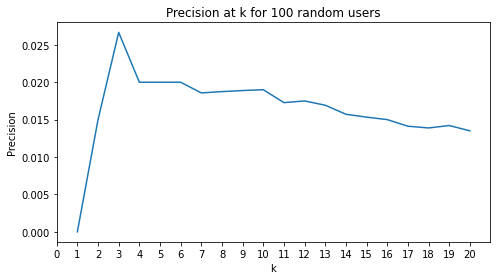

In [42]:
avg_p_at_k_all = jr.calculate_avg_precision_at_k(p_at_k_all=p_at_k_all)

#### Exploring low P@k scores

Here we can see that precision is very low. I started to dig into the predictions and P@k for different users. Here is an example of P@k for user `LAteaGIRL`:

In [43]:
print("P@k(u) for LAteaGIRL:", p_at_k_dict['LAteaGIRL'])
print("User is following", G.out_degree('LAteaGIRL'), "people")
print("User is followed by", G.in_degree('LAteaGIRL'), "people")

P@k(u) for LAteaGIRL: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
User is following 4 people
User is followed by 8 people


Precision is 0.0 at every level for `LAteaGIRL`! Why? Because we don't have much data to work with for her. _#ColdStartProblem_

You can see that she only follows 4 other users in the training data. If the random 80/20 split between train and test data is applied to `LAteaGIRL`, then there is only 1 potential user that could be successfully recommended. This is essentially a cold start problem because we don't have enough information about a user to make strongly supported personalized recommendations to them. Potential improvements to deal with cold start in this network are discussed in the Conclusion.

For this discussion, we can explore only providing personalized recommendations to users who meet a given threshold of connections. In the `calculate_precision_at_k` function above, this threshold is denoted as `H_threshold` and refers to the degree of a node in the entire training/test set.

**Note:** The `H_threshold` is not used for anything other than verifying that a node has a high enough degree to warrant personalized recommendations. No data is passed or infered in the function that would cause data leakage.

#### Visualizing degree distribution

To get a clearer picture of the degree of each node, I found a handy function from this <a href="https://stackoverflow.com/questions/53958700/plotting-the-degree-distribution-of-a-graph-using-nx-degree-histogram">StackOverflow topic</a> that allows us to see that a majority of users are following fewer than 10 people in the training data. In fact, 800 users are only following 2 people! We can try higher `H_threshold` values to improve precision and provide alternative recommendations/information gathering prompts for those users for whom we still have limited information.

In [27]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

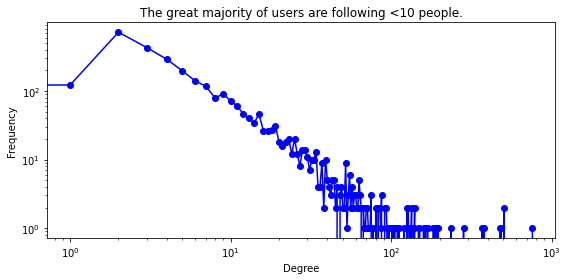

In [28]:
out_degree_freq = degree_histogram_directed(G, out_degree=True, in_degree=False)
plt.figure(figsize=(8, 4)) 
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title("The great majority of users are following <10 people.")
plt.tight_layout()

#### Trying new `H_threshold` values

Now that we know why our precision was so low, we can try higher `H_threshold` values and see what impact it has on precision as well as network coverage. We'll start out by using pulling from 100 users with different threshold values.

##### Threshold: 10, n users: 100

Here we can see that Precision has increased significantly, peaking around 7% at `k=3`. Unfortunately, only 29/100 sampled users crossed the 10 connection threshold, so that's 29% coverage.

In [34]:
p_at_k_all, p_at_k_dict = jr.calculate_precision_at_k(G, all_jaccard_coefficients,
                                                      test_data=test, H=edges,
                                                      H_threshold=10, n=100,
                                                      k=20, seed=123)

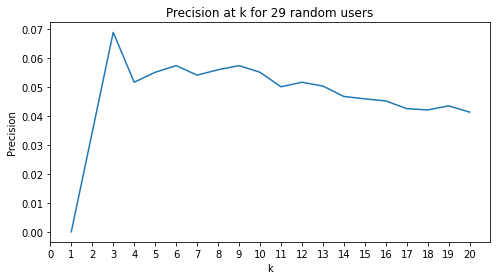

In [35]:
avg_p_at_k_all = jr.calculate_avg_precision_at_k(p_at_k_all=p_at_k_all)

##### Threshold: 20, n users: 100

Precision has increased again, reaching a high of 11%. Coverage has dropped to 15%.

In [36]:
p_at_k_all, p_at_k_dict = jr.calculate_precision_at_k(G, all_jaccard_coefficients,
                                                      test_data=test, H=edges,
                                                      H_threshold=20, n=100,
                                                      k=20, seed=123)

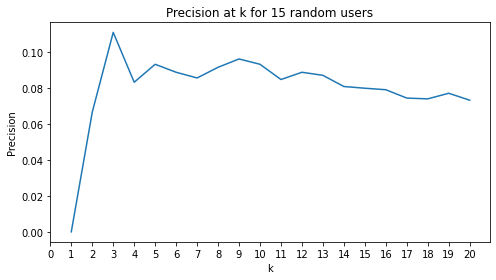

In [37]:
avg_p_at_k_all = jr.calculate_avg_precision_at_k(p_at_k_all=p_at_k_all)

##### Threshold: 20, n users: 500

Precision has dropped slightly, topping out at 9.5%. Coverage at 17%. We could surely improve the precision by increasing the `H_threshold` value, but coverage becomes too limited to be practical.

In [38]:
p_at_k_all, p_at_k_dict = jr.calculate_precision_at_k(G, all_jaccard_coefficients,
                                                      test_data=test, H=edges,
                                                      H_threshold=20, n=500,
                                                      k=20, seed=123)

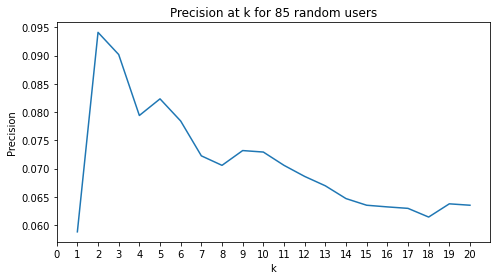

In [39]:
avg_p_at_k_all = jr.calculate_avg_precision_at_k(p_at_k_all=p_at_k_all)

## Conclusion

There are a few important conclusions that can be drawn here:
* The Jaccard coefficient is a usable method for identifying potential matches with unary data.
* If a baseline precision is required by the business, then the `H_threshold` can be adjusted to provide that baseline for users who meet the threshold criterion.

### Dealing with the cold start problem

Like any recommender, this tool struggles with the cold start problem. Here are a couple of ideas I've had to deal with that:

* Recommend users who are followed by many people. The out-degree distribution chart above can be easily switched to an in-degree chart. If those users with high in-degree are highly active, then this could be a good way to engage new users and avoid onboarding-stage attrition. 
* Introduce a walkthrough in the product to encourage people to read tea reviews and follow those they find interesting. Could also enrich data by asking the user what kinds of teas they like and then recommending they follow people who also like those teas. I will explore this user-item-user relationship in future notebooks.

**Note:** This network dataset is not complete yet. I'm still scraping data and growing the dataset. I only have partial data for many users, so as I get more data for those users, new edges will appear in the dataset that were always there in the network but weren't visible yet.